<a href="https://cocl.us/DL0320EN_TOP_IMAGE">
    <img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0320EN/Assets/Images/Top.png" width="750" alt="IBM 10TB Storage" />
</a>


<h1>Classifying European Money Denominations: Training a Pre-trained model  </h1>


<h2>Table of Contents</h2>


<p>In this lab, you will train the pre-trained model to classify the European currency. You will use the dataset object you created in the previous lab.</p>
<ul>
    <li><a href="#gen">Create Image Dataset Generator</a></li>
    <li><a href="#ques">Questions</a>
        <ol>
            <li><a href="q31">Question 3.1: Preparation</a></li>
            <li><a href="q32">Question 3.2: Train the model</a></li>
            <li><a href="q33">Question 3.3: Plot 5 Random Images with their predictions</a></li>
            <li><a href="q34">Question 3.4: Use the second model <code>Densenet121</code> to do the prediction</a></li>
        </ol>
    </li>
    <li><a href="#save">Save the trained model</a></li>
</ul>

<p>Estimated Time Needed: <b>60 mins</b></p>
<hr>


<h2>Preparation</h2>


<a href="https://cocl.us/DL0320EN_storage">
    <img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0320EN/Assets/Images/ObjectStorage.png" width="750" alt="cognitive class" />
</a>


Download the datasets you needed for this lab.


In [1]:
# You can comment out this box when you already have the dataset
# Step 1: Ctrl + A : Select all
# Step 2: Ctrl + / : Comment out all; if everything selected has been comment out alreaday, then uncomment all

# Download Training Dataset
!wget --quiet -O /resources/data/training_data_pytorch.tar.gz https://cocl.us/DL0320EN_TRAIN_TAR_PYTORCH
!tar -xzf  /resources/data/training_data_pytorch.tar.gz -C /resources/data --exclude '.*'

# Download Validation Dataset
!wget --quiet -O /resources/data/validation_data_pytorch.tar.gz https://cocl.us/DL0320EN_VALID_TAR_PYTORCH
!tar -xzf  /resources/data/validation_data_pytorch.tar.gz -C /resources/data --exclude '.*'

Import the PyTorch Modules needed in the lab.


In [2]:
# Import PyTorch Modules will be used in the lab

import torch 
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import pandas
from torchvision import transforms
import torch.nn as nn
torch.manual_seed(0)
from torch.optim.lr_scheduler import CosineAnnealingLR

Import Non-PyTorch Modules 


In [3]:
# Import Non-PyTorch Modules will be used in the lab

import time
from imageio import imread
from matplotlib.pyplot import imshow
import matplotlib.pylab as plt
import pandas as pd
from PIL import Image, ImageDraw, ImageFont
import random
import numpy as np

<hr>


<h2 id="gen">Create Dataset Class and Object</h2>


In this section, you use the dataset class from the last section.


The denomination, file name and the class variable for the training and validation data are stored in the following csv file.


In [4]:
# Url that contains CSV files

train_csv_file = 'https://cocl.us/DL0320EN_TRAIN_CSV'
validation_csv_file = 'https://cocl.us/DL0320EN_VALID_CSV'

The training images and validation images  are stored in the following directories.


In [5]:
# Absolute path for finding the directory contains image datasets

train_data_dir = '/resources/data/training_data_pytorch/'
validation_data_dir = '/resources/data/validation_data_pytorch/'

Use  the dataset class you created in the last lab. You can cut and paste it to here:


In [6]:
# Create Dateaset Class

class Dataset(Dataset):
    
    # Constructor
    def __init__(self, csv_file, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.data_name = pd.read_csv(csv_file)
        self.len = self.data_name.shape[0] 
    
    # Get Length
    def __len__(self):
        return self.len
    
    # Getter
    def __getitem__(self, idx):
        img_name = self.data_dir + self.data_name.iloc[idx, 2]
        image = Image.open(img_name)
        y = self.data_name.iloc[idx, 3]
        if self.transform:
            image = self.transform(image)
        return image, y

Use the constructor <code>compose</code> to perform the following sequence of transformations in the order they are given, call the object <code>composed</code>


In [7]:
# Construct the composed object for transforming the image

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
composed = transforms.Compose([transforms.Resize((224, 224))
                               , transforms.ToTensor()
                               , transforms.Normalize(mean, std)])

Create a training dataset and validation dataset object using the csv file stored in the variables the <code>train_csv_file</code> and <code>validation_csv_file</code>. The directories are stored in the variable <code>train_data_dir</code> and <code>validation_data_dir</code>. Set the parameter <code>transform</code> to the object <code>composed</code>. 


In [8]:
# Create the train dataset and validation dataset

train_dataset = Dataset(transform=composed
                        ,csv_file=train_csv_file
                        ,data_dir=train_data_dir)

validation_dataset = Dataset(transform=composed
                          ,csv_file=validation_csv_file
                          ,data_dir=validation_data_dir)

<hr>


<h2 id="ques">Questions</h2>


<h3 id="q31">Question 3.1: Preparation</h3><b>5 points</b>


<b>Step 1</b>: Load the pre-trained model <code>resnet18</code> Set the parameter <code>pretrained</code> to true.


In [17]:
# Step 1: Load the pre-trained model resnet18
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model = models.resnet18(pretrained=True)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

<b>Step 2</b>: The following lines of code will set the attribute <code>requires_grad</code> to <code>False</code>. As a result, the parameters will not be affected by training.


In [18]:
for param in model.parameters():
    param.requires_grad = False

<code>resnet18</code> is used to classify 1000 different objects; as a result, the last layer has 1000 outputs.  The 512 inputs come from the fact that the previously hidden layer has 512 outputs. 


<b>Step 3</b>: Replace the output layer <code>model.fc</code> of the neural network with a <code>nn.Linear</code> object, to classify 7 different bills. For the parameters <code>in_features </code> remember the last hidden layer has 512 neurons.


In [19]:
# Step 3: Re-defined the last layer

model.fc = nn.Linear(512, 7)

Print out the model in order to show whether you get the correct answer.<br> <b>(Your peer reviewer is going to mark based on what you print here.)</b>


In [20]:
# Print the model (PLEASE DO NOT MODIFY THIS BOX)

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

<h3 id="q32">Question 3.2: Train the model</h3><b>5 points</b>


<b>Step 1</b>: Create a cross entropy criterion function 


In [21]:
# Step 1: Create the loss function

criterion = nn.CrossEntropyLoss()

<b>Step 2</b>: Create a training loader and validation loader object, the batch size is <i>15</i> and <i>10</i> respectively .


In [22]:
# Step 2: Create the data loader

train_bsize = 10
val_bsize = 15

training_loader = DataLoader(train_dataset, batch_size=val_bsize, shuffle=True,
                             pin_memory=True)
validation_loader = DataLoader(validation_dataset, batch_size=train_bsize,
                               shuffle=False, pin_memory=True)

<b>Step 3</b>: Use the following optimizer to minimize the loss 


In [23]:
# Step 3: Use the pre-defined optimizer Adam with learning rate 0.003

trainable_params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(trainable_params, lr=1e-3)

<b>Step 4</b>: Train the model for 20 epochs, save the loss in a list as will as the accuracy on the validation data for every epoch. The entire process may take 6.5 minutes. Print the validation accuracy for each epoch during the epoch loop. Then, plot the training loss for each epoch and validation error for each epoch.


In [25]:
epochs = 20
loss = []       # Per epoch
accuracy = []   # " "
scheduler = CosineAnnealingLR(optimizer, T_max=7, eta_min=0)

for epoch in range(epochs):

    # Training
    loss_epoch = 0.0
    for batch, (x, y) in enumerate(training_loader):
        x = x.to(device)
        y = y.to(device)
        loss_batch = criterion(model(x), y)
        loss_epoch += loss_batch.item()

        optimizer.zero_grad()
        loss_batch.backward()
        optimizer.step()
        scheduler.step()
        print(f"{epoch}.{batch} {loss_batch.item()}")
    loss.append(loss_epoch / len(training_loader))

    # Validation
    with torch.no_grad():
        model.eval()
        correct = 0
        for batch, (x, y) in enumerate(validation_loader):
            x = x.to(device)
            y = y.to(device)
            y_hat = model(x).max(dim=1)[1]
            correct += (y_hat == y).sum().item()
        accuracy.append(correct / len(validation_dataset))
        model.train()
    print(f"Epoch: {epoch} accuracy: {accuracy[-1]}")

0.0 2.1938207149505615
0.1 1.9167100191116333
0.2 2.046680212020874
0.3 1.9898459911346436
0.4 1.9401130676269531
Epoch: 0 accuracy: 0.17142857142857143
1.0 1.8487993478775024
1.1 1.736387014389038
1.2 1.7560875415802002
1.3 1.7889763116836548
1.4 1.731996774673462
Epoch: 1 accuracy: 0.15714285714285714
2.0 1.7391935586929321
2.1 1.705851674079895
2.2 1.6003868579864502
2.3 1.693586826324463
2.4 1.5925929546356201
Epoch: 2 accuracy: 0.5142857142857142
3.0 1.4647154808044434
3.1 1.437706470489502
3.2 1.3846904039382935
3.3 1.4130812883377075
3.4 1.8764588832855225
Epoch: 3 accuracy: 0.5428571428571428
4.0 1.4568690061569214
4.1 1.3156505823135376
4.2 1.3982462882995605
4.3 1.1996207237243652
4.4 1.3997396230697632
Epoch: 4 accuracy: 0.7714285714285715
5.0 1.2704459428787231
5.1 1.3825069665908813
5.2 1.2638388872146606
5.3 1.2008894681930542
5.4 1.1793460845947266
Epoch: 5 accuracy: 0.9142857142857143
6.0 1.1428552865982056
6.1 1.0925624370574951
6.2 1.0706348419189453
6.3 1.02513158321

<b>Step 5</b>: Plot the training loss for each iteration<br> <b>(Your peer reviewer is going to mark based on what you plot here.)</b> 


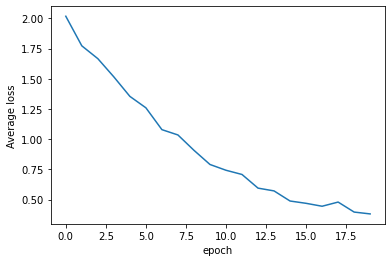

In [26]:
# Step 5: Plot the loss for training dataset

plt.plot(loss)
plt.ylabel("Average loss")
plt.xlabel("epoch")
plt.show()

<b>Step 6</b>: Plot the validation accuracy for each epoch<br> <b>(Your peer reviewer is going to mark based on what you plot here.)</b> 


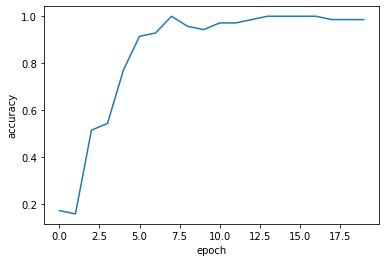

In [27]:
# Step 6: Plot the accuracy for valdiation dataset

plt.plot(accuracy)
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()

<h3 id="q33">Question 3.3: Plot 5 Random Images with their predictions</h3><b>5 points</b>


Create a test dataset using validation data. And, create your own <code>plot_random_image()</code> function to plot 5 random images which index is in the <code>numbers</code> list. Run the function to plot image, print the predicted label and print a string indicate whether it has been correctly classified or mis-classified.<br> <b>(Your peer reviewer is going to mark based on what you plot here.)</b>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


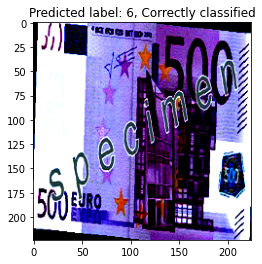

predicted $500, Correctly classified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


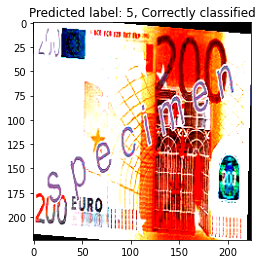

predicted $200, Correctly classified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


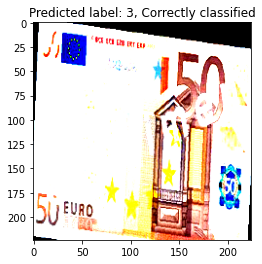

predicted: $50, Correctly classified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


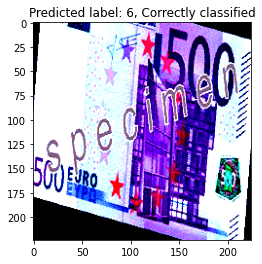

predicted $500, Correctly classified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


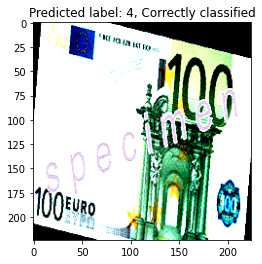

predicted: $100, Correctly classified


In [29]:
# Plot the images with labels

look_up = {0: 'predicted: $5', 1: 'predicted: $10', 2: 'predicted: $20',
           3: 'predicted: $50', 4: 'predicted: $100', 5: 'predicted $200',
           6: 'predicted $500'}


def plot_random_image():
    """Plot 5 random images from the validation set."""
    model.eval()
    with torch.no_grad():
        for number in random.sample(range(70), 5):
            X, Y = validation_dataset[number]
            y_hat = model(X[None, :, :, :].to(device)).max(dim=1)[1]
            title = "Correctly" if y_hat.item() == Y else "Incorrectly"
            plt.imshow(X.cpu().permute(1, 2, 0), vmin=0, vmax=255)
            plt.title(f"Predicted label: {y_hat.item()}, {title} classified")
            plt.show()
            print(f"{look_up[y_hat.item()]}, {title} classified")
    model.train()


plot_random_image()

<h3>Question 3.4: Use the second model <code>Densenet121</code> to do the prediction</h3><b>3 points</b>


Repeat the steps in Question 3.1, 3.2 to predict the result using <code>models.densenet121</code> model. Then, print out the last validation accuracy.


<p>Steps:</p>
<ol>
    <li>Load the pre-trained model Densenet</li>
    <li>Replace the last classification layer with only 7 classes</li>
    <li>Set the configuration (parameters)</li>
    <li>Train the model</li>
    <li>Print the last validation accuracy</li>
</ol>


Hint:

<ul>
    <li>The second last layer for this model has 1024 outputs.</li>
    <li>The last layer for <code>Densenet121</code> can be accessed by <code>model.classifier</code></li>
    <li>Use the criterion function <code>nn.CrossEntropyLoss()</code></li>
    <li>Train Batch Size: 15; Validation Batch Size: 10</li>
    <li>Optimizer: Adam with learning rate 0.003</li>
    <li>10 Epoches. Otherwise, it will take too long.</li>
</ul>


You are welcome to try any pattern of setting and find out the best result. Please name the model variable as <code>model_des</code>.<br> <b>(Your peer reviewer is going to mark based on what you print here.)</b>


0.0 2.0671050548553467
0.1 1.8875491619110107
0.2 1.7888603210449219
0.3 1.8350722789764404
0.4 1.6449451446533203
0.5 1.9713157415390015
0.6 1.921748399734497
Epoch: 0 accuracy: 0.18571428571428572
1.0 1.9554294347763062
1.1 1.6689300537109375
1.2 1.6465604305267334
1.3 1.7037208080291748
1.4 1.5158817768096924
1.5 1.6116399765014648
1.6 1.441115140914917
Epoch: 1 accuracy: 0.6142857142857143
2.0 1.540048599243164
2.1 1.4167182445526123
2.2 1.3258042335510254
2.3 1.604803442955017
2.4 1.3901599645614624
2.5 1.4382792711257935
2.6 1.1980831623077393
Epoch: 2 accuracy: 0.8571428571428571
3.0 1.1702775955200195
3.1 1.234740138053894
3.2 1.2204755544662476
3.3 1.2856911420822144
3.4 1.104727864265442
3.5 1.1562190055847168
3.6 1.1448993682861328
Epoch: 3 accuracy: 0.9285714285714286
4.0 1.0755283832550049
4.1 1.1229153871536255
4.2 1.1703420877456665
4.3 1.016680359840393
4.4 1.0885765552520752
4.5 1.1295840740203857
4.6 1.051047921180725
Epoch: 4 accuracy: 0.9428571428571428
5.0 0.994250

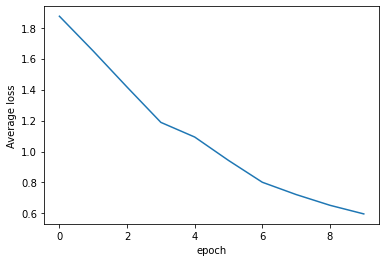

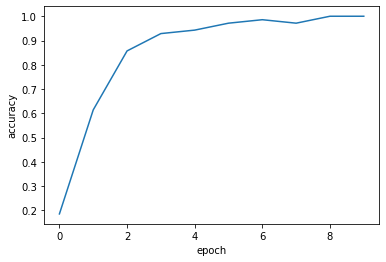

In [32]:
model_des = models.densenet121(pretrained=True)

for param in model_des.parameters():
    param.requires_grad = False

# Replace the output layer model_des.fc of the neural network with
# a nn.Linear object, to classify 7 different bills. For the parameters
# in_features  remember the last hidden layer has 1024 neurons.
model_des.classifier = nn.Linear(1024, 7)
model_des.to(device)

train_bsize = 15
val_bsize = 10
criterion = nn.CrossEntropyLoss()

training_loader = DataLoader(train_dataset, batch_size=val_bsize, shuffle=True,
                             pin_memory=True)
validation_loader = DataLoader(validation_dataset, batch_size=train_bsize,
                               shuffle=False, pin_memory=True)

trainable_params = [p for p in model_des.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(trainable_params, lr=1e-3)
scheduler = CosineAnnealingLR(optimizer, T_max=5, eta_min=0)
epochs = 10

loss = []       # Per epoch
accuracy = []   # " "

for epoch in range(epochs):

    # Training
    loss_epoch = 0.0
    for batch, (x, y) in enumerate(training_loader):
        x = x.to(device)
        y = y.to(device)
        loss_batch = criterion(model_des(x), y)
        loss_epoch += loss_batch.item()

        optimizer.zero_grad()
        loss_batch.backward()
        optimizer.step()
        scheduler.step()
        print(f"{epoch}.{batch} {loss_batch.item()}")
    loss.append(loss_epoch / len(training_loader))

    # Validation
    with torch.no_grad():
        model_des.eval()
        correct = 0
        for batch, (x, y) in enumerate(validation_loader):
            x = x.to(device)
            y = y.to(device)
            y_hat = model_des(x).max(dim=1)[1]
            correct += (y_hat == y).sum().item()
        accuracy.append(correct / len(validation_dataset))
        model_des.train()
    print(f"Epoch: {epoch} accuracy: {accuracy[-1]}")

plt.plot(loss)
plt.ylabel("Average loss")
plt.xlabel("epoch")
plt.show()

plt.plot(accuracy)
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()

<h2 id="#save">Save the trained model</h2>


Save the trained model for the following chapters


In [34]:
# Save the model

torch.save(model, "resnet18_pytorch.pt")
torch.save(model_des, "densenet121_pytorch.pt")

<a href="https://cocl.us/DLO0320EN_notebook_bott">
    <img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0320EN/Assets/Images/Bottom.png" width="750" alt="cognitive class" />
</a>


<h2>About the Authors:</h2> 

<a href="https://www.linkedin.com/in/joseph-s-50398b136/">Joseph Santarcangelo</a> has a PhD in Electrical Engineering, his research focused on using machine learning, signal processing, and computer vision to determine how videos impact human cognition. Joseph has been working for IBM since he completed his PhD.


Other contributors: <a href="https://www.linkedin.com/in/michelleccarey/">Michelle Carey</a>, <a href="www.linkedin.com/in/jiahui-mavis-zhou-a4537814a">Mavis Zhou</a>, <a href="https://www.linkedin.com/in/yi-leng-yao-84451275/">Yi Leng Yao</a>


<hr>


Copyright © 2018 <a href="cognitiveclass.ai?utm_source=bducopyrightlink&utm_medium=dswb&utm_campaign=bdu">cognitiveclass.ai</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.
